## Import your stuff

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from pydelfi import delfi
from pydelfi import ndes

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
from simulators.jla_supernovae import jla_simulator as jla

JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/Users/justinalsing/Dropbox/science/pydelfi-tf2-test/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [3]:
lower = np.array([0, -1.5, -20, 0, 0, -0.5]).astype(np.float32)
upper = np.array([0.6, 0, -18, 1, 6, 0.5]).astype(np.float32)
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(lower.shape[0])])

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
from pydelfi import score
theta_fiducial = np.array([0.2, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load in the compressed data

In [5]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

For this example let's define a stack of 6 NDEs; one Masked Autoregressive Flow (MAF) and five Mixture Density Networks (MDNs) with 1-5 full-rank Gaussian components respectively

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=6,
            n_data=6,
            n_mades=5,
            n_hidden=[30,30], 
            activation=tf.keras.layers.LeakyReLU(0.01),
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
            all_layers=True)]

NDEs += [ndes.MixtureDensityNetwork(
            n_parameters=6,
            n_data=6, 
            n_components=i+1,
            n_hidden=[30,30], 
            activation=tf.keras.layers.LeakyReLU(0.01))
        for i in range(5)]

Instructions for updating:
Use ref() instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv=Finv, 
                            theta_fiducial=theta_fiducial, 
                            param_names=['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir="simulators/jla_supernovae/results",
                            filename="jla",
                            optimiser=tf.keras.optimizers.Adam,
                            optimiser_arguments=None,
                            dtype=tf.float32,
                            posterior_chain_length=200,
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs

Training terminated for model 0 at epoch 67.
Training terminated for model 1 at epoch 191.
Training terminated for model 3 at epoch 191.
Training terminated for model 5 at epoch 197.
Training terminated for model 2 at epoch 206.
Training terminated for model 4 at epoch 265.
Sampling approximate posterior...
Done.
Removed no burn in


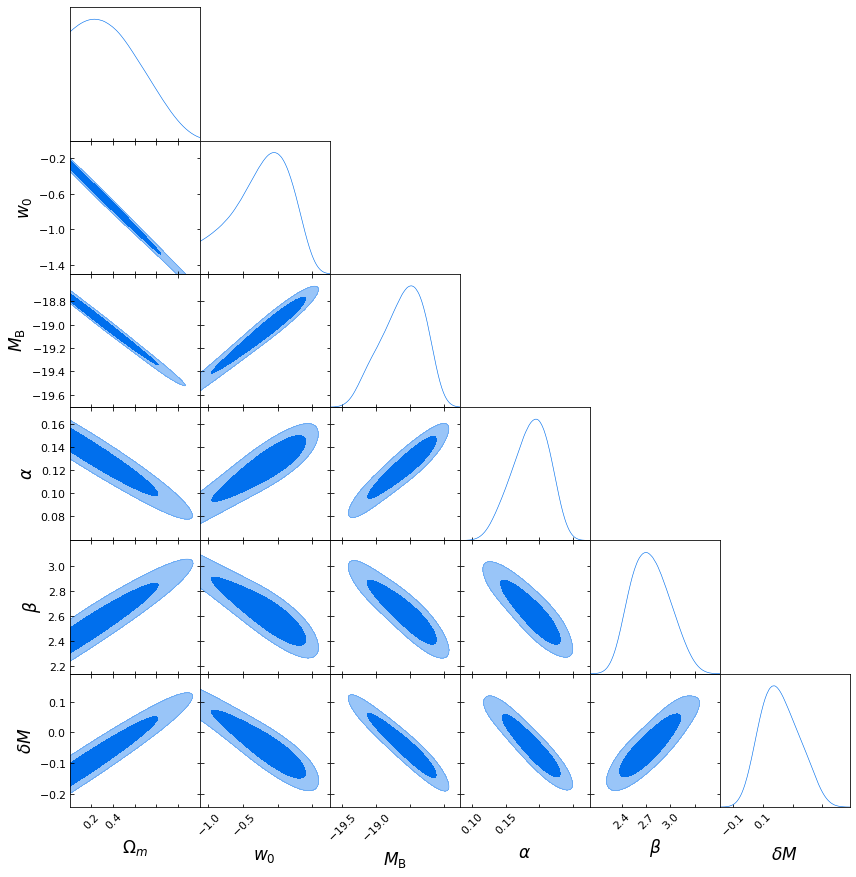

In [8]:
DelfiEnsemble.fisher_pretraining(n_batch=5000, epochs=1000, patience=20, plot=True)

## Sequential Neural Likelihood

Training terminated for model 3 at epoch 34.


Training terminated for model 2 at epoch 143.


Training terminated for model 0 at epoch 151.


Training terminated for model 5 at epoch 190.


Training terminated for model 1 at epoch 230.
Training terminated for model 4 at epoch 255.
Sampling approximate posterior...
Done.
Removed no burn in


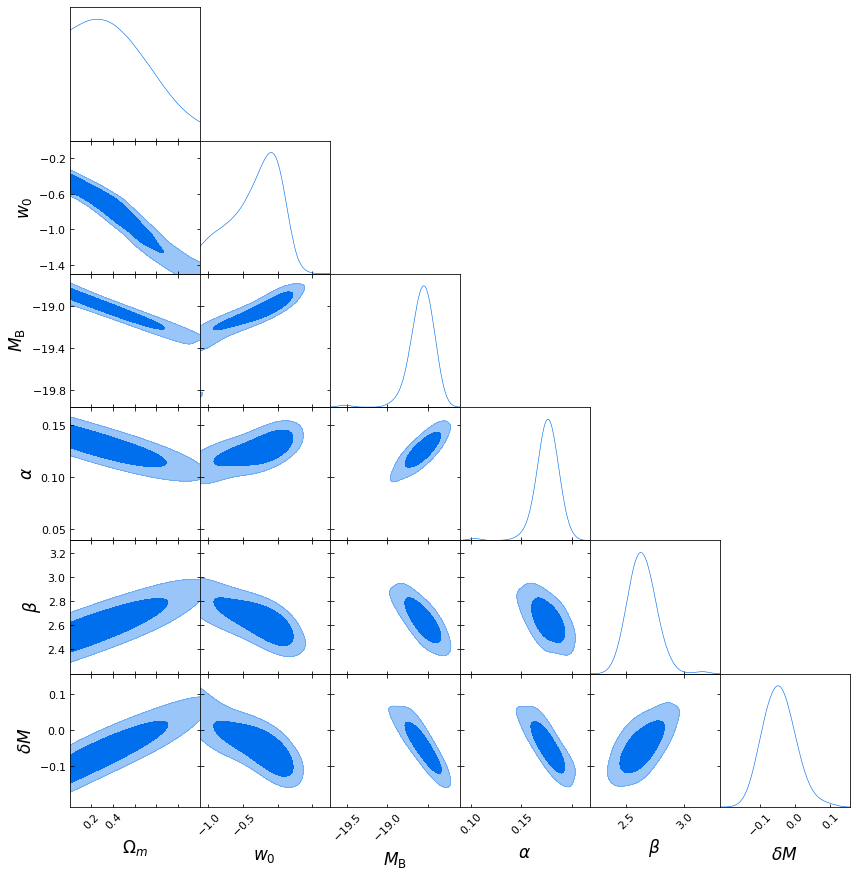

Population 1/12
Sampling proposal density...
Done.


Training terminated for model 2 at epoch 56.


Training terminated for model 1 at epoch 66.


Training terminated for model 4 at epoch 81.


Training terminated for model 3 at epoch 96.
Training terminated for model 5 at epoch 96.


Training terminated for model 0 at epoch 109.
Sampling approximate posterior...
Done.
Removed no burn in


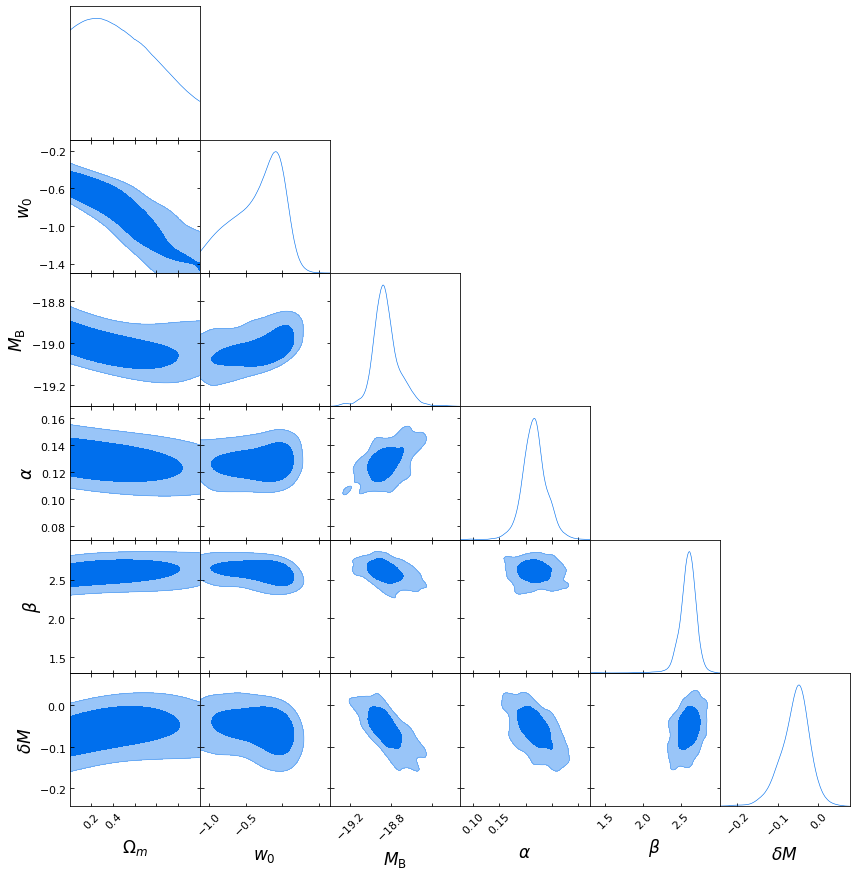

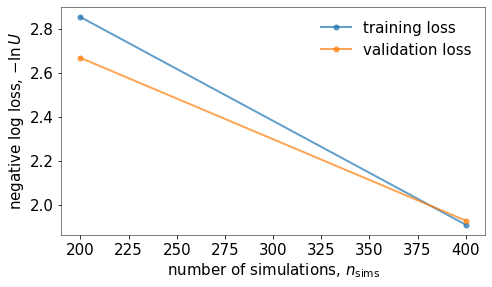

Population 2/12
Sampling proposal density...
Done.


Training terminated for model 3 at epoch 27.
Training terminated for model 0 at epoch 29.


Training terminated for model 1 at epoch 30.
Training terminated for model 5 at epoch 54.
Training terminated for model 4 at epoch 70.


Training terminated for model 2 at epoch 92.
Sampling approximate posterior...
Done.
Removed no burn in


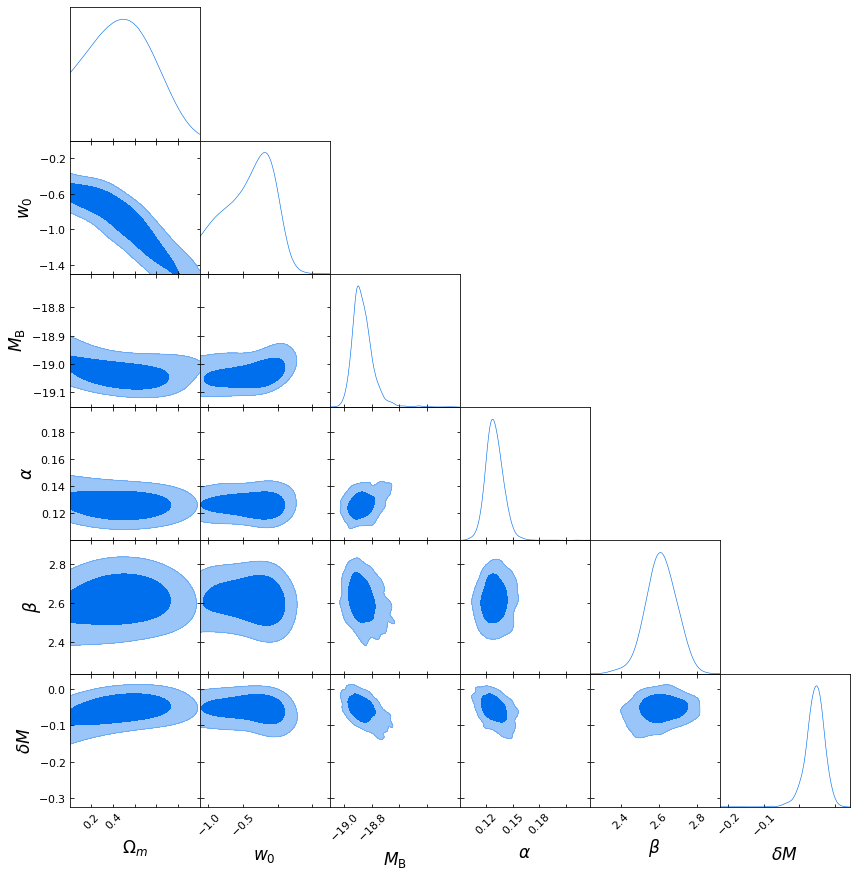

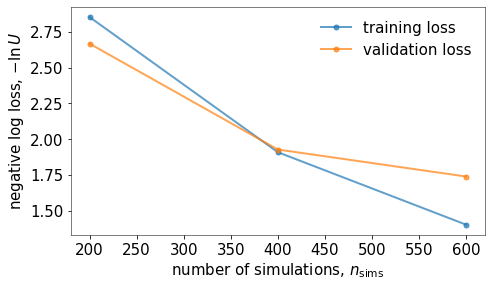

Population 3/12
Sampling proposal density...
Done.


Training terminated for model 0 at epoch 12.
Training terminated for model 1 at epoch 13.


Training terminated for model 5 at epoch 16.


Training terminated for model 4 at epoch 17.


Training terminated for model 2 at epoch 18.


Training terminated for model 3 at epoch 20.
Sampling approximate posterior...
Done.
Removed no burn in


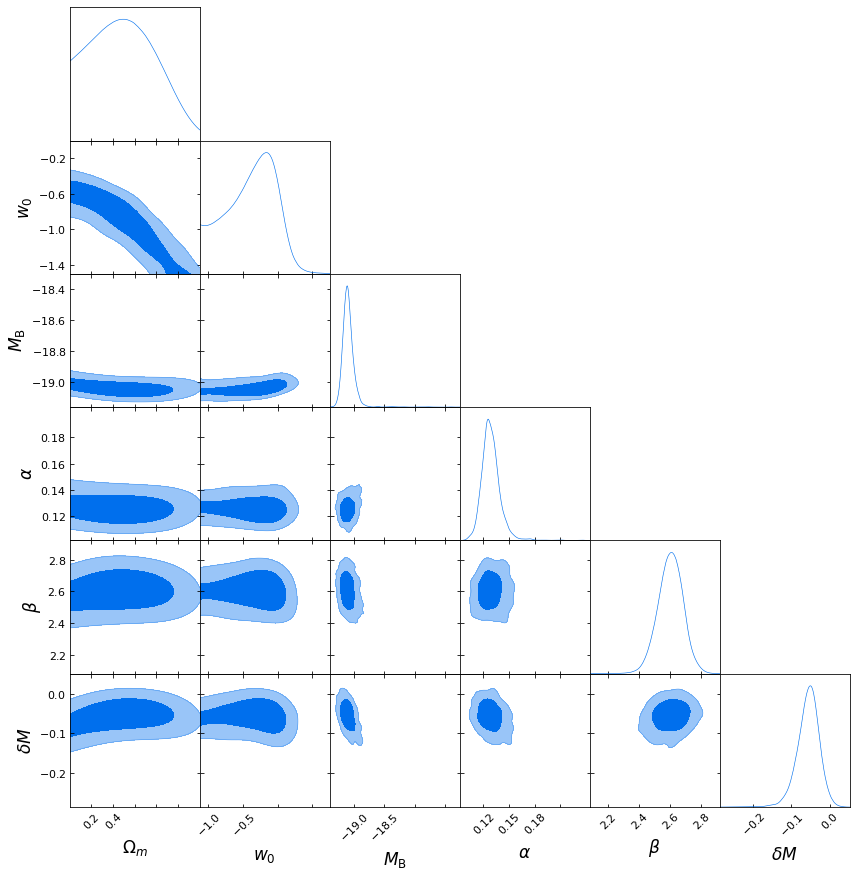

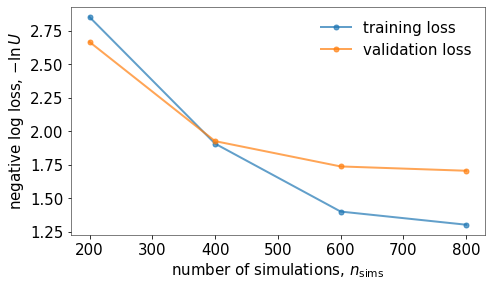

Population 4/12
Sampling proposal density...
Done.


Training terminated for model 2 at epoch 18.
Training terminated for model 0 at epoch 19.


Training terminated for model 5 at epoch 21.


Training terminated for model 1 at epoch 22.


Training terminated for model 4 at epoch 26.
Training terminated for model 3 at epoch 34.
Sampling approximate posterior...
Done.
Removed no burn in


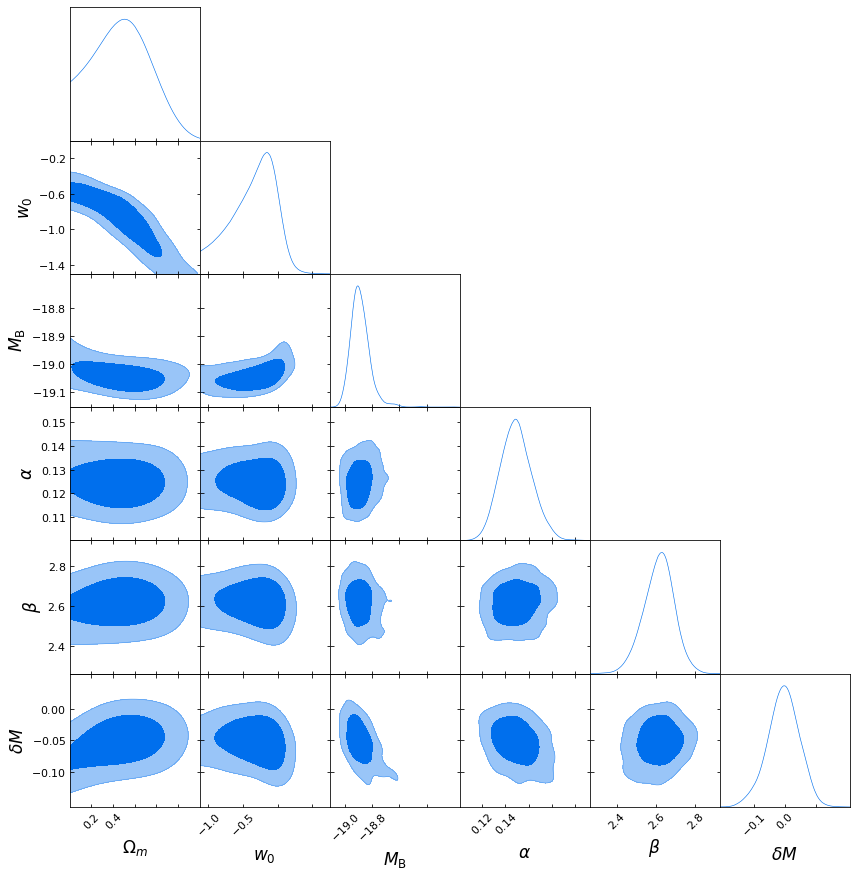

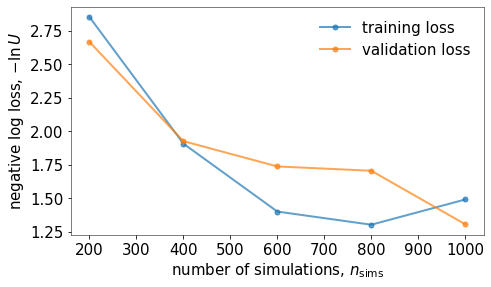

Population 5/12
Sampling proposal density...
Done.


Training terminated for model 0 at epoch 11.
Training terminated for model 2 at epoch 12.
Training terminated for model 3 at epoch 17.
Training terminated for model 5 at epoch 21.
Training terminated for model 4 at epoch 23.


Training terminated for model 1 at epoch 27.
Sampling approximate posterior...
Done.
Removed no burn in


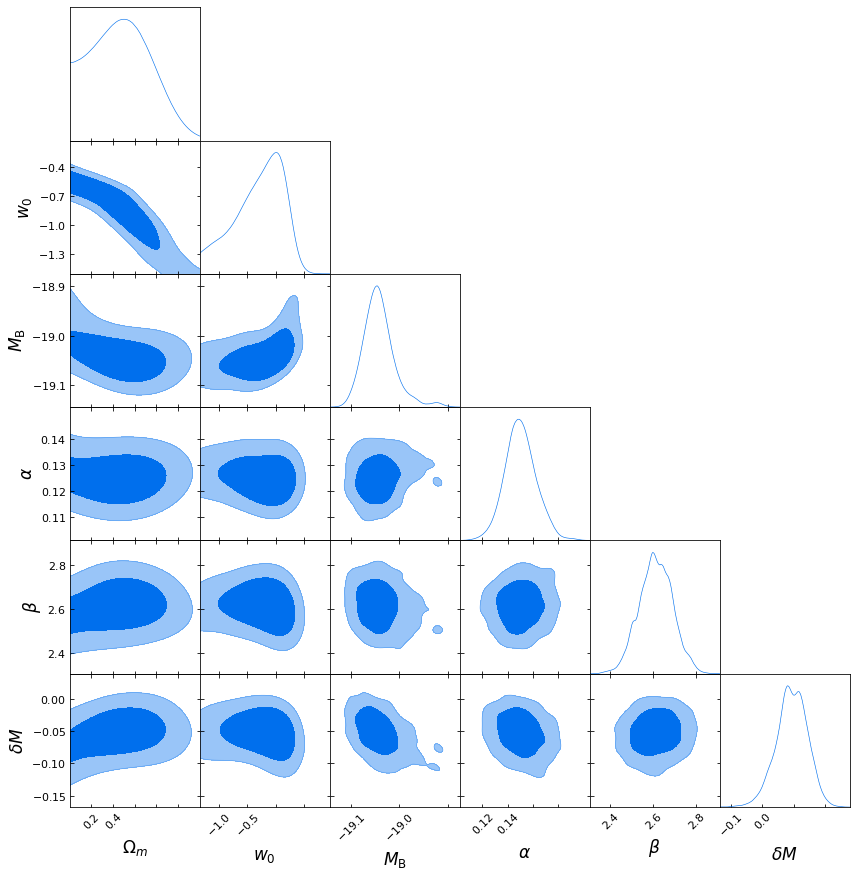

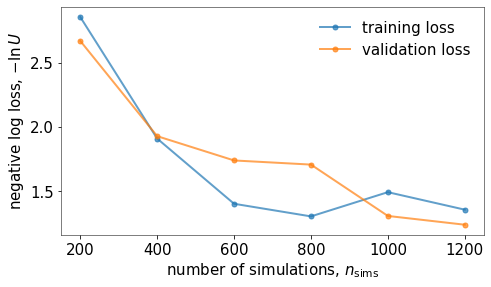

Population 6/12
Sampling proposal density...
Done.


Training terminated for model 0 at epoch 11.
Training terminated for model 2 at epoch 11.
Training terminated for model 5 at epoch 11.
Training terminated for model 3 at epoch 14.
Training terminated for model 4 at epoch 15.
Training terminated for model 1 at epoch 23.
Sampling approximate posterior...
Done.
Removed no burn in


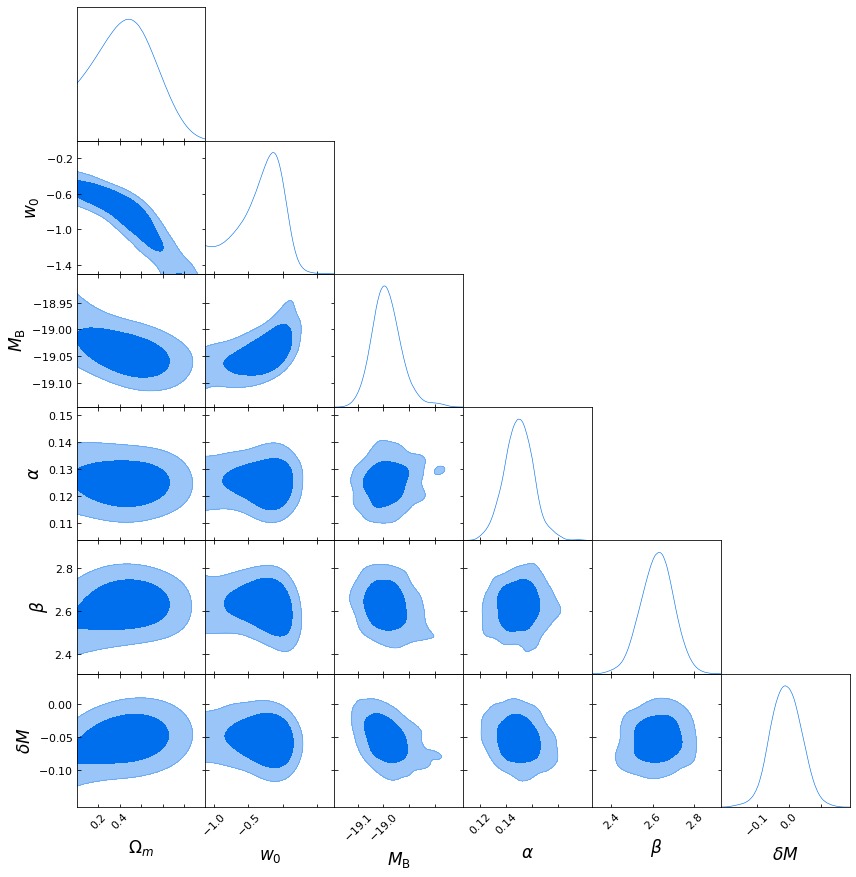

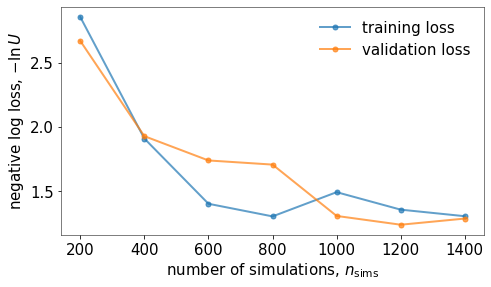

Population 7/12
Sampling proposal density...
Done.


Training terminated for model 0 at epoch 11.
Training terminated for model 2 at epoch 11.
Training terminated for model 4 at epoch 11.
Training terminated for model 5 at epoch 11.


Training terminated for model 3 at epoch 15.
Training terminated for model 1 at epoch 18.
Sampling approximate posterior...
Done.
Removed no burn in


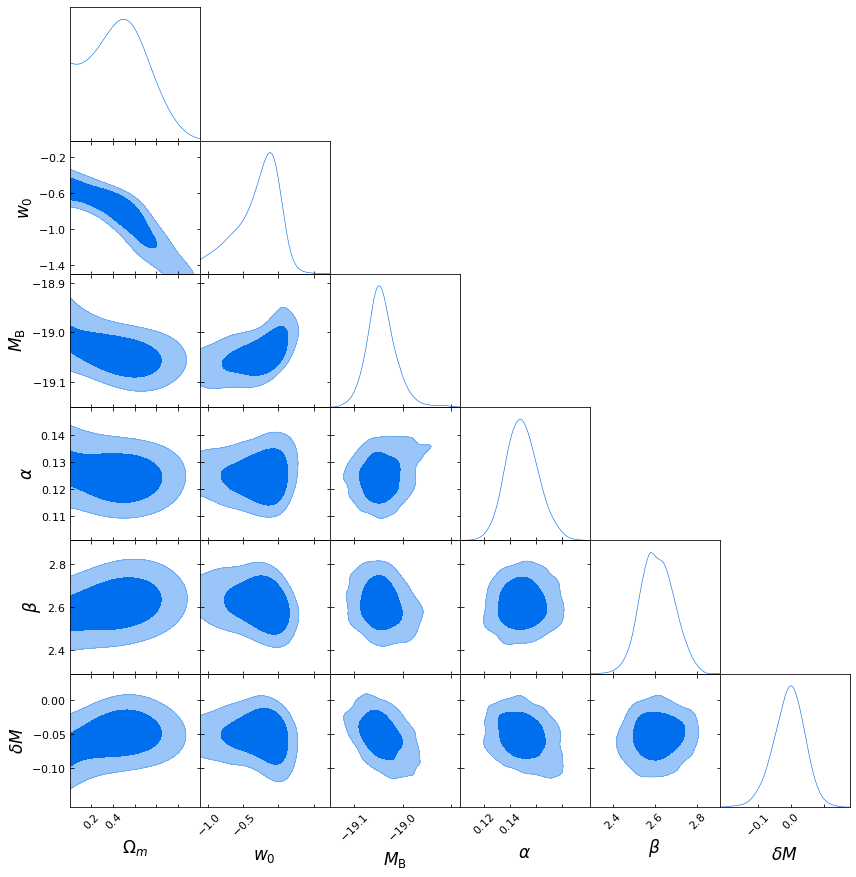

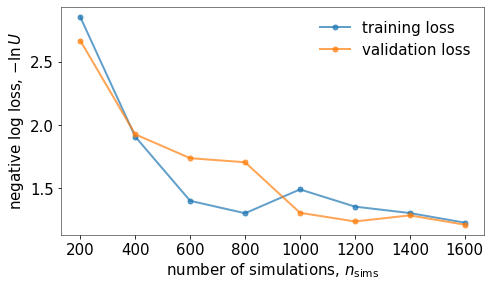

Population 8/12
Sampling proposal density...
Done.


Training terminated for model 0 at epoch 11.
Training terminated for model 2 at epoch 11.
Training terminated for model 4 at epoch 11.
Training terminated for model 5 at epoch 11.
Training terminated for model 3 at epoch 12.
Training terminated for model 1 at epoch 19.
Sampling approximate posterior...
Done.
Removed no burn in


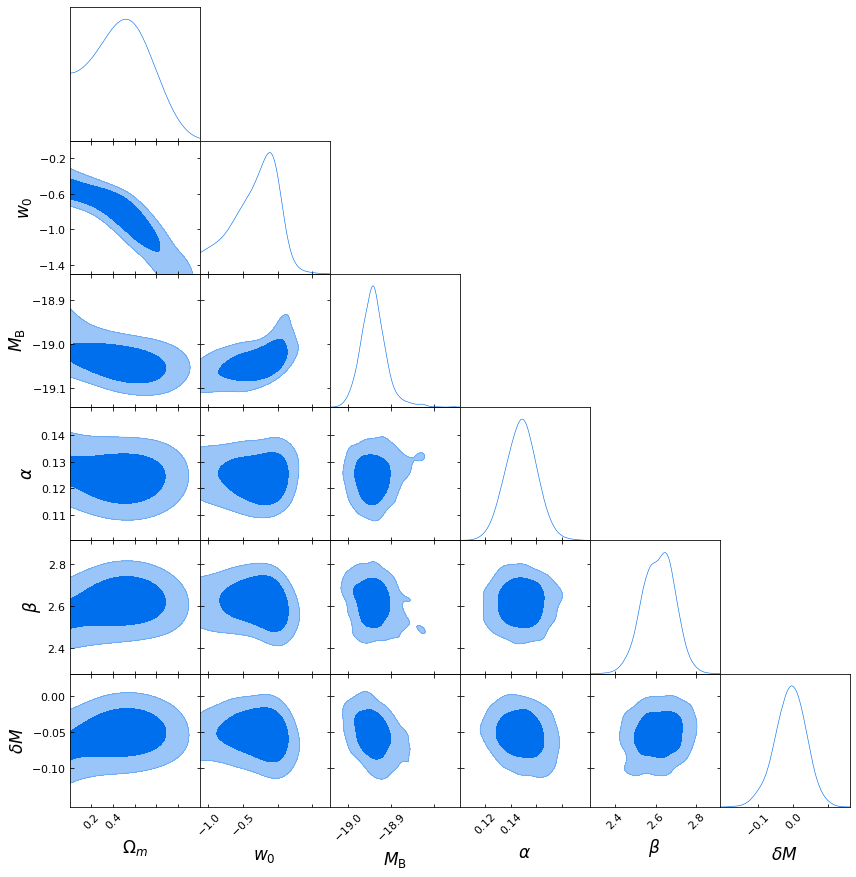

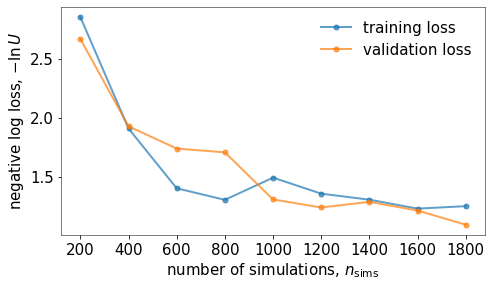

Population 9/12
Sampling proposal density...
Done.


Training terminated for model 2 at epoch 11.
Training terminated for model 4 at epoch 11.


Training terminated for model 0 at epoch 12.


Training terminated for model 5 at epoch 13.
Training terminated for model 3 at epoch 14.
Training terminated for model 1 at epoch 19.
Sampling approximate posterior...
Done.
Removed no burn in


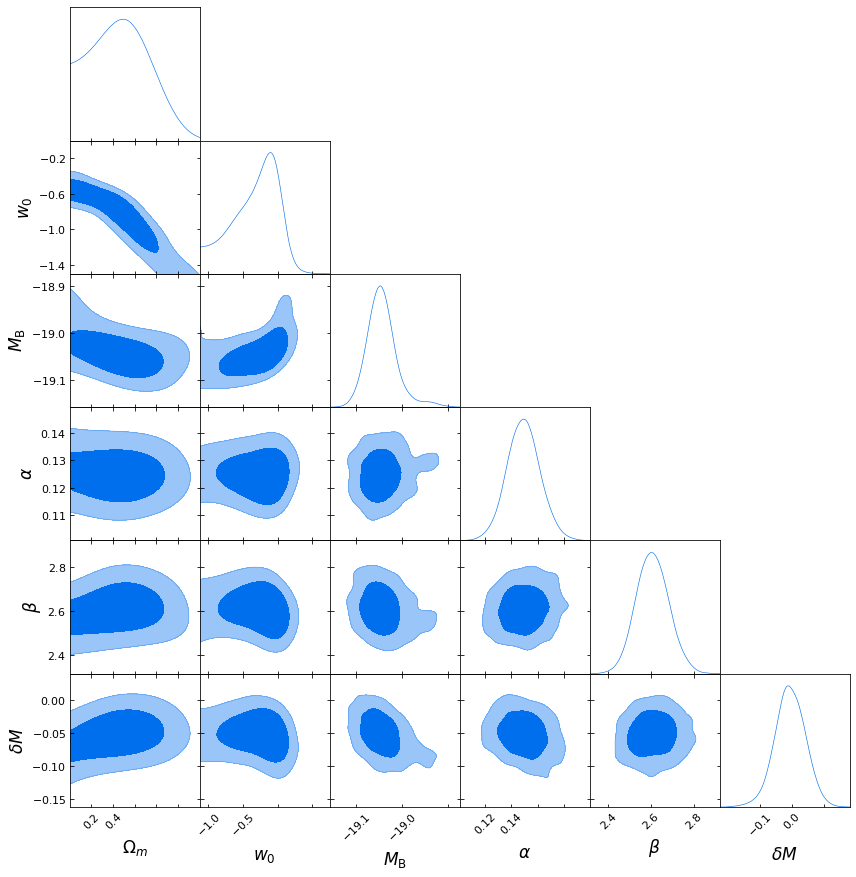

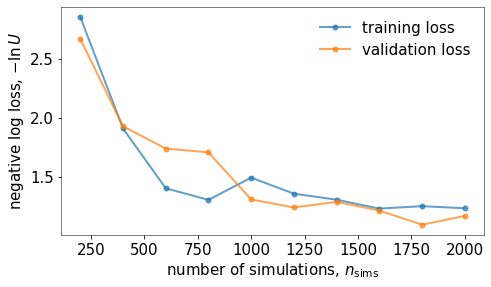

Population 10/12
Sampling proposal density...
Done.


Training terminated for model 4 at epoch 11.


Training terminated for model 0 at epoch 12.


Training terminated for model 3 at epoch 14.
Training terminated for model 5 at epoch 14.


Training terminated for model 2 at epoch 18.
Training terminated for model 1 at epoch 21.
Sampling approximate posterior...


Done.
Removed no burn in


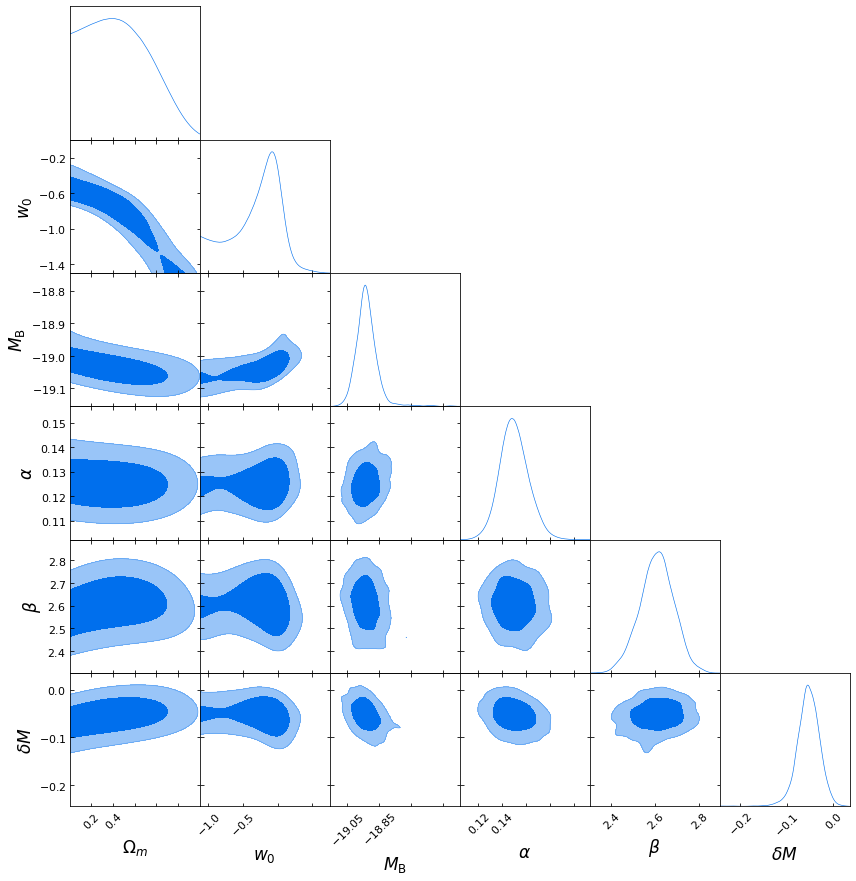

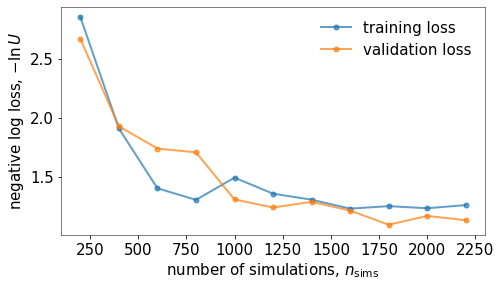

Population 11/12
Sampling proposal density...
Done.


Training terminated for model 3 at epoch 11.
Training terminated for model 4 at epoch 11.


Training terminated for model 0 at epoch 12.


Training terminated for model 2 at epoch 18.


Training terminated for model 5 at epoch 19.
Training terminated for model 1 at epoch 23.
Sampling approximate posterior...
Done.
Removed no burn in


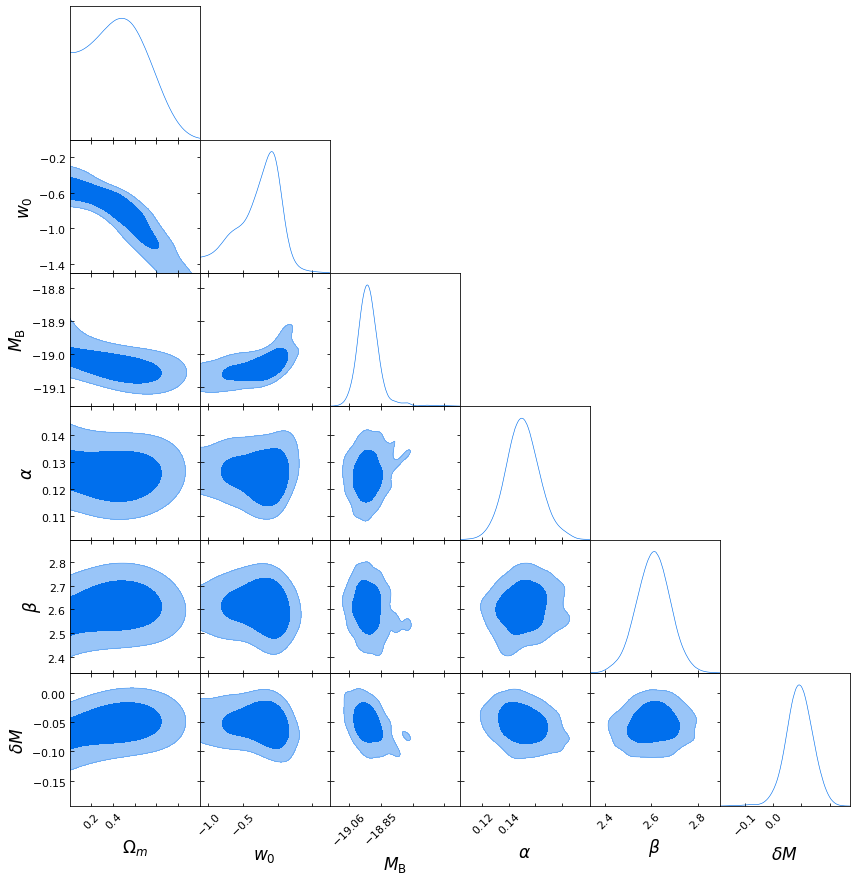

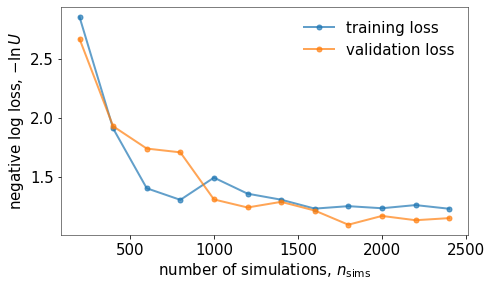

Population 12/12
Sampling proposal density...
Done.


Training terminated for model 0 at epoch 14.
Training terminated for model 3 at epoch 14.
Training terminated for model 4 at epoch 14.
Training terminated for model 2 at epoch 15.
Training terminated for model 5 at epoch 15.
Training terminated for model 1 at epoch 16.
Sampling approximate posterior...
Done.
Removed no burn in


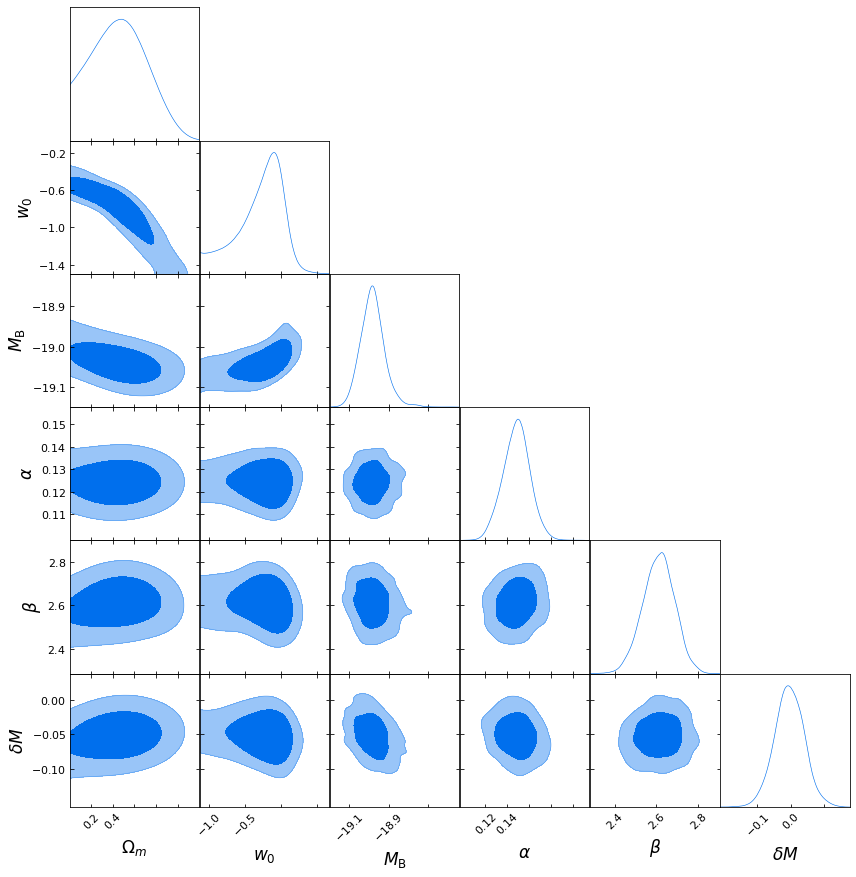

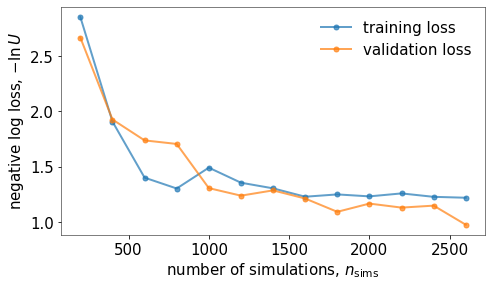

In [9]:
n_initial = 200
n_batch = 200
n_populations = 12

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, plot=True, save_intermediate_posteriors=True)

## Sample the learned posterior

In [10]:
posterior_samples, posterior_weights, log_posterior_values = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


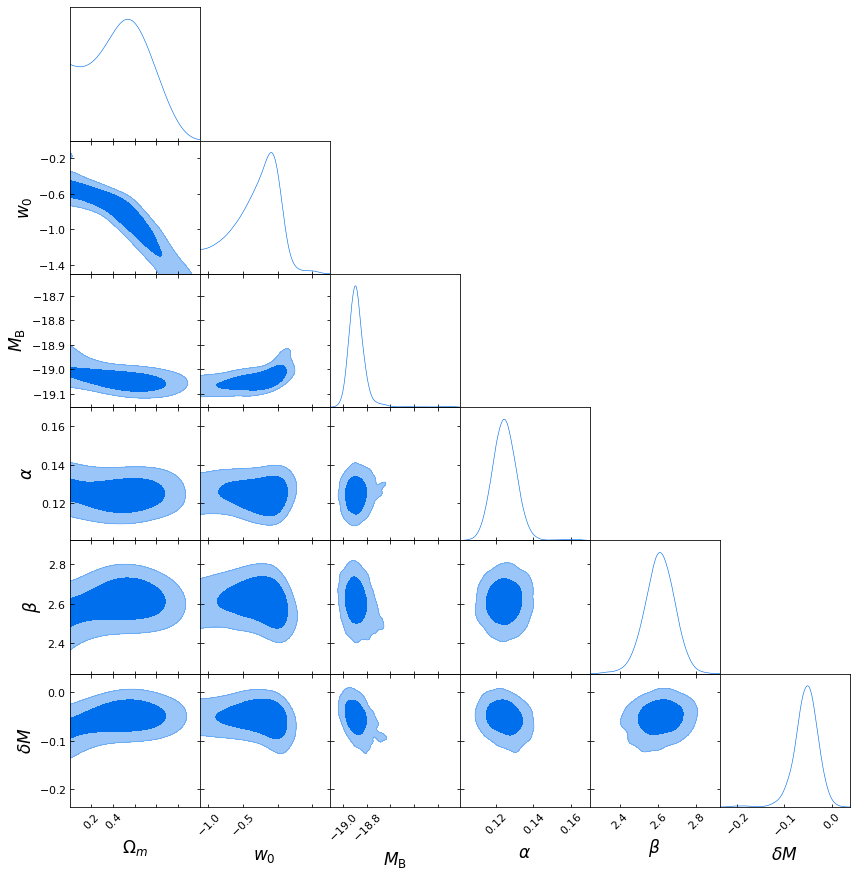

In [11]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])